<a href="https://colab.research.google.com/github/nahomHmichael/Twitter-Data-Analysis-10acad/blob/main/topic_modeling_using_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install pyLDAvis 
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing packages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import nltk
import numpy as np
import spacy

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load #  for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz #  for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Natural Language Processing Toolkit
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
# from nltk.stem import PorterStemmer (I played around with Stemmer and decided to use Lemmatizer instead)
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
model_df = pd.read_csv('/content/drive/MyDrive/clean_processed_tweet_data.csv')
model_df = model_df.fillna("")
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,\n\nLets focus in one very specific zone of th...,-1,0.000000e+00,0.08125,en,15760,2,i_ameztoy,232,20497,2621,,City,,,
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,#China's media explains the military reasons ...,0,-1.000000e-01,0.10000,en,6967,201,ZIisq,3,65,272,,China,,,
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...","China even cut off communication, they don't a...",-1,0.000000e+00,0.00000,en,2166,0,Fin21Free,0,85,392,,XiJinping,,Netherlands,
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1,1.000000e-01,0.35000,en,2166,0,Fin21Free,0,85,392,,XiJinping,,Netherlands,
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...","I’m sorry, I thought Taiwan was an independen...",0,-6.938894e-18,0.55625,en,17247,381,VizziniDolores,0,910,2608,,,,"Ayent, Schweiz",


In [80]:
model_df['place'].nunique()

4410

In [6]:
def clean_text_cleaner(clean_text: str) -> str:
    cleaned_text = re.sub('\n', '', clean_text)
    cleaned_text = re.findall(r'[a-zA-Z]+', cleaned_text)
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'http.*', "", cleaned_text)

    return cleaned_text

In [7]:
model_df['clean_text'] = model_df['clean_text'].apply(clean_text_cleaner)
model_df['clean_text']

0        Lets focus in one very specific zone of the we...
1        China s media explains the military reasons fo...
2        China even cut off communication they don t an...
3        Putin to XiJinping I told you my friend Taiwan...
4        I m sorry I thought Taiwan was an independent ...
                               ...                        
21995    A good infographic of China s missile launches...
21996    A good infographic of China s missile launches...
21997                     Reuters Thanks Pelosi smart move
21998    Taiwan people s Desire for Unification With Ch...
21999    Taiwan people s Desire for Unification With Ch...
Name: clean_text, Length: 22000, dtype: object

In [8]:
model_df.shape

(22000, 20)

In [81]:
flattened_words_df = pd.DataFrame(
    [word for words_list in model_df.clean_text
    for word in words_list.split(' ')],
    columns=['word'])

flattened_words_df

,word
0,Lets
1,focus
2,in
3,one
4,very
...,...
421416,from
421417,Taiwan
421418,s
421419,National


Text(0, 0.5, 'count')

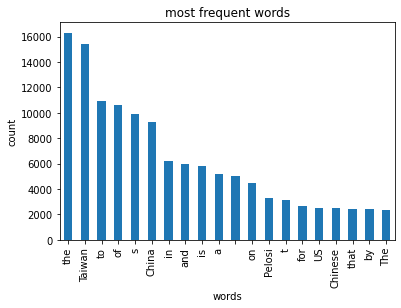

In [82]:
flattened_words_df.word.value_counts()[:20].plot(kind='bar')
plt.title('most frequent words')
plt.xlabel('words')
plt.ylabel('count')

In [9]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              22000 non-null  object 
 1   statuses_count          22000 non-null  int64  
 2   source                  22000 non-null  object 
 3   original_text           22000 non-null  object 
 4   clean_text              22000 non-null  object 
 5   sentiment               22000 non-null  int64  
 6   polarity                22000 non-null  float64
 7   subjectivity            22000 non-null  float64
 8   lang                    22000 non-null  object 
 9   favorite_count          22000 non-null  int64  
 10  retweet_count           22000 non-null  int64  
 11  original_author         22000 non-null  object 
 12  screen_count            22000 non-null  int64  
 13  followers_count         22000 non-null  int64  
 14  friends_count           22000 non-null

In [10]:
# Check missing values

print("The number of missing value(s): {}".format(model_df.isnull().sum().sum()))
print("Columons having columns value:{}".format(model_df.columns[model_df.isnull().any()]))

The number of missing value(s): 0
Columons having columns value:Index([], dtype='object')


In [11]:
# Check for "NaN" values
model_df.isna().any() 

created_at                False
statuses_count            False
source                    False
original_text             False
clean_text                False
sentiment                 False
polarity                  False
subjectivity              False
lang                      False
favorite_count            False
retweet_count             False
original_author           False
screen_count              False
followers_count           False
friends_count             False
possibly_sensitive        False
hashtags                  False
user_mentions             False
place                     False
place_coord_boundaries    False
dtype: bool

In [12]:
def preprocessTweets(tweet):
    
    # Remove punctuations
    unpunctuated_words = [char for char in tweet_tokens if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words) 

In [13]:
# function to obtain adjectives from tweets

def getAdjectives(tweet):
    tweet = word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  

In [14]:
# get called 'Tweets_Adjectives'
model_df['Tweets_Adjectives'] = model_df['clean_text'].apply(getAdjectives)

In [15]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,Lets focus in one very specific zone of the we...,-1,0.000000e+00,0.08125,en,15760,...,i_ameztoy,232,20497,2621,,City,,,,specific western
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,China s media explains the military reasons fo...,0,-1.000000e-01,0.10000,en,6967,...,ZIisq,3,65,272,,China,,,,military
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",China even cut off communication they don t an...,-1,0.000000e+00,0.00000,en,2166,...,Fin21Free,0,85,392,,XiJinping,,Netherlands,,t clown
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",Putin to XiJinping I told you my friend Taiwan...,1,1.000000e-01,0.35000,en,2166,...,Fin21Free,0,85,392,,XiJinping,,Netherlands,,vassal Ukrainian s
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",I m sorry I thought Taiwan was an independent ...,0,-6.938894e-18,0.55625,en,17247,...,VizziniDolores,0,910,2608,,,,"Ayent, Schweiz",,sorry independent own military


In [16]:
def preprocessTweetsSentiments(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # initialize an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

In [17]:
model_df['Tweets_Sentiments'] = model_df['clean_text'].apply(preprocessTweetsSentiments)

In [18]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,Lets focus in one very specific zone of the we...,-1,0.000000e+00,0.08125,en,15760,...,232,20497,2621,,City,,,,specific western,Lets focus in one very specific zone of the we...
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,China s media explains the military reasons fo...,0,-1.000000e-01,0.10000,en,6967,...,3,65,272,,China,,,,military,China s medium explains the military reason fo...
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",China even cut off communication they don t an...,-1,0.000000e+00,0.00000,en,2166,...,0,85,392,,XiJinping,,Netherlands,,t clown,China even cut off communication they don t an...
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",Putin to XiJinping I told you my friend Taiwan...,1,1.000000e-01,0.35000,en,2166,...,0,85,392,,XiJinping,,Netherlands,,vassal Ukrainian s,Putin to XiJinping I told you my friend Taiwan...
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",I m sorry I thought Taiwan was an independent ...,0,-6.938894e-18,0.55625,en,17247,...,0,910,2608,,,,"Ayent, Schweiz",,sorry independent own military,I m sorry I thought Taiwan wa an independent c...


In [19]:
# Extract all tweets into one long string with each word separate with a "space"
tweets_long_string = model_df['Tweets_Adjectives'].tolist()
tweets_long_string = " ".join(tweets_long_string)

In [24]:
# Function to create blue color for twitter logo
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

In [25]:
# Import Twitter Logo
image = np.array(Image.open('/content/drive/MyDrive/twitter_logo.png'))

In [26]:
from wordcloud import STOPWORDS,WordCloud
import random

(-0.5, 794.5, 788.5, -0.5)

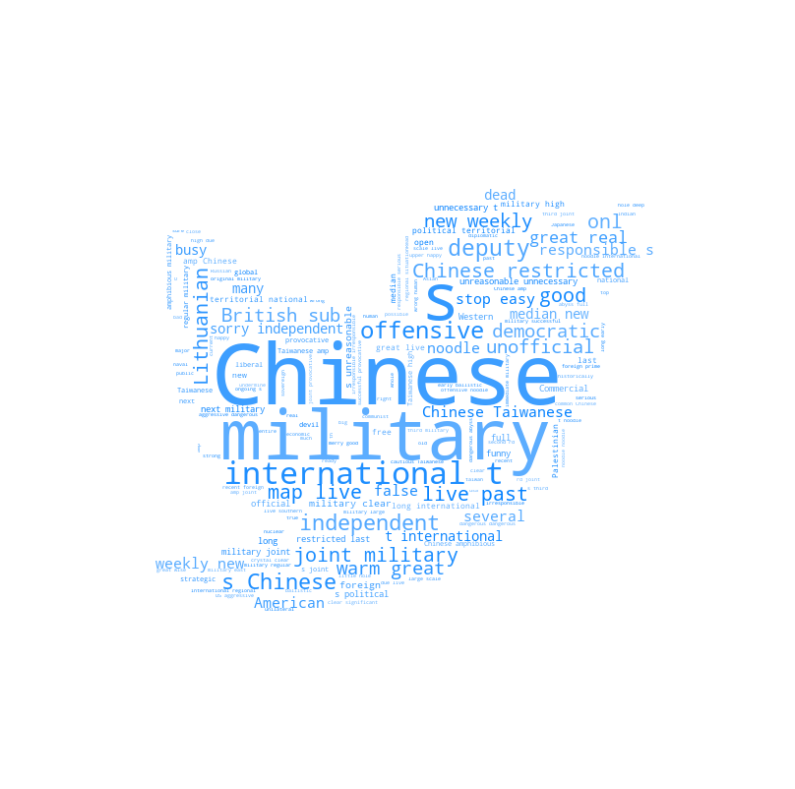

In [27]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

# generate the word cloud
twitter_wc.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')

In [28]:
# import textblob
from textblob import TextBlob

In [30]:
# Create function to obtain Subjectivity Score
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# Create function to obtain Polarity Score
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Create function to obtain Sentiment category
def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [31]:
# Apply all functions above to respective columns
# also used validate the dataset sentimnt values
model_df['Subjectivity'] = model_df['Tweets_Sentiments'].apply(getSubjectivity)
model_df['Polarity'] = model_df['Tweets_Sentiments'].apply(getPolarity)
model_df['Sentiment'] = model_df['Polarity'].apply(getSentimentTextBlob)

In [32]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments,Subjectivity,Polarity,Sentiment
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,Lets focus in one very specific zone of the we...,-1,0.000000e+00,0.08125,en,15760,...,,City,,,,specific western,Lets focus in one very specific zone of the we...,0.08125,0.000000e+00,Neutral
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,China s media explains the military reasons fo...,0,-1.000000e-01,0.10000,en,6967,...,,China,,,,military,China s medium explains the military reason fo...,0.10000,-1.000000e-01,Negative
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",China even cut off communication they don t an...,-1,0.000000e+00,0.00000,en,2166,...,,XiJinping,,Netherlands,,t clown,China even cut off communication they don t an...,0.00000,0.000000e+00,Neutral
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",Putin to XiJinping I told you my friend Taiwan...,1,1.000000e-01,0.35000,en,2166,...,,XiJinping,,Netherlands,,vassal Ukrainian s,Putin to XiJinping I told you my friend Taiwan...,0.35000,1.000000e-01,Positive
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",I m sorry I thought Taiwan was an independent ...,0,-6.938894e-18,0.55625,en,17247,...,,,,"Ayent, Schweiz",,sorry independent own military,I m sorry I thought Taiwan wa an independent c...,0.55625,-6.938894e-18,Negative


In [33]:
model_df['Sentiment'].value_counts()

Neutral     9088
Positive    8211
Negative    4701
Name: Sentiment, dtype: int64

In [127]:
bar_plot =  model_df['Sentiment'].value_counts().rename_axis('Sentiment').to_frame('Total Tweets').reset_index()   


In [128]:
bar_plot

,Sentiment,Total Tweets
0,Neutral,9088
1,Positive,8211
2,Negative,4701


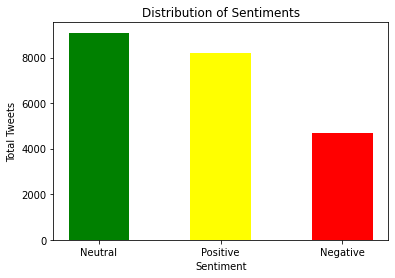

In [129]:
x = bar_plot['Sentiment']
y = bar_plot['Total Tweets']
c = ["green", "yellow", "red"]
plt.bar(x, y, width=0.5, color=c)
plt.xlabel("Sentiment")
plt.ylabel("Total Tweets")
plt.title("Distribution of Sentiments")
plt.show()

In [89]:
sentiment_tweet = model_df[['Tweets_Sentiments','polarity']]

In [90]:
score = pd.Series([getSentimentTextBlob(row_value) for row_value in sentiment_tweet['polarity']])


In [91]:
sentiment_tweet = pd.concat([sentiment_tweet, score.rename("score")], axis=1)

In [92]:
sentiment_tweet.head()

,Tweets_Sentiments,polarity,score
0,Lets focus in one very specific zone of the we...,0.000000e+00,Neutral
1,China s medium explains the military reason fo...,-1.000000e-01,Negative
2,China even cut off communication they don t an...,0.000000e+00,Neutral
3,Putin to XiJinping I told you my friend Taiwan...,1.000000e-01,Positive
4,I m sorry I thought Taiwan wa an independent c...,-6.938894e-18,Negative


In [93]:
scoremap = pd.Series([1 if row_value == 'Positive' else 0 for row_value in sentiment_tweet['score']])

In [42]:
len(scoremap)

22000

In [94]:
sentiment_tweet['scoremap'] = scoremap
X = sentiment_tweet['Tweets_Sentiments']
y = sentiment_tweet['scoremap']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
print(X_train.size,',' , X_test.size)
print(X_test.size, ',',y_test.size)

17600 , 4400
4400 , 4400


In [97]:
# scaling the input
clf = LinearSVC()

In [98]:
unigram_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1, 1))
bigram_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (2, 2))
hybrid_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1, 2))

In [99]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = unigram_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [100]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = unigram_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)


In [101]:
np.mean(prediction == y_test)

0.9593181818181818

In [102]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = bigram_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [103]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = bigram_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [104]:
np.mean(prediction == y_test)

0.9263636363636364

In [105]:
# X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = hybrid_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
model = clf.fit(X_train_counts, y_train)

In [106]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = hybrid_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [107]:
np.mean(prediction == y_test)

0.9559090909090909

# Using PyLDAvis

In [108]:
from nltk.stem import PorterStemmer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

In [109]:
# Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [110]:
topic_model_df = model_df.copy(deep=True)
topic_model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments,Subjectivity,Polarity,Sentiment
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,Lets focus in one very specific zone of the we...,-1,0.000000e+00,0.08125,en,15760,...,,City,,,,specific western,Lets focus in one very specific zone of the we...,0.08125,0.000000e+00,Neutral
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,China s media explains the military reasons fo...,0,-1.000000e-01,0.10000,en,6967,...,,China,,,,military,China s medium explains the military reason fo...,0.10000,-1.000000e-01,Negative
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",China even cut off communication they don t an...,-1,0.000000e+00,0.00000,en,2166,...,,XiJinping,,Netherlands,,t clown,China even cut off communication they don t an...,0.00000,0.000000e+00,Neutral
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",Putin to XiJinping I told you my friend Taiwan...,1,1.000000e-01,0.35000,en,2166,...,,XiJinping,,Netherlands,,vassal Ukrainian s,Putin to XiJinping I told you my friend Taiwan...,0.35000,1.000000e-01,Positive
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",I m sorry I thought Taiwan was an independent ...,0,-6.938894e-18,0.55625,en,17247,...,,,,"Ayent, Schweiz",,sorry independent own military,I m sorry I thought Taiwan wa an independent c...,0.55625,-6.938894e-18,Negative


In [126]:
#class PrepareData:
 #     def __init__(self,df):
  #      self.df=df
    
   #   def preprocess_data(self):
        #model_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
        #model_df['clean_text']=model_df['clean_text'].astype(str)
        #model_df['clean_text'] = model_df['clean_text'].str.replace('[^\w\s]\n','')
        #model_df['clean_text'] = model_df['clean_text'].apply(lambda x: x.lower())
        #model_df['clean_text']= model_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
        #model_df['clean_text'] = model_df['clean_text'].str.replace('\w*\d\w*\n','')
        
        #stemmer = PorterStemmer()
        #model_df['clean_text'] = model_df['clean_text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))


        
      
        #model_df['clean_text'] = model_df['clean_text']

        #Converting tweets to list of words For feature engineering
        #sentence_list = [tweet for tweet in model_df['clean_text']]
        #word_list = [sent.split() for sent in sentence_list]
        # print(word_list)

        #Create dictionary which contains Id and word 
        #word_to_id = corpora.Dictionary(word_list) #generate unique tokens
        #  we can see the word to unique integer mapping
        # print(word_to_id.token2id)
        # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
        #corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
        

        #return word_list, word_to_id, corpus_1


In [111]:
def get_hastags_words_list():
    hashtagList = []
    for hashtags in topic_model_df.hashtags:
        if(hashtags != ""):
            hashtagList += hashtags.split(',')

    return hashtagList

hashtag = get_hastags_words_list()

data = [word for sentence in topic_model_df.clean_text for word in sentence.split(' ')]

In [112]:
hashtag[:5]

['City', 'China', 'XiJinping', 'XiJinping', 'Taiwan']

In [113]:
data[:10]

['Lets',
 'focus',
 'in',
 'one',
 'very',
 'specific',
 'zone',
 'of',
 'the',
 'western']

In [114]:
data_words = data + hashtag
data_words = [word for word in data_words if word != '']
data_words[:5]

['Lets', 'focus', 'in', 'one', 'very']

In [115]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['L', 'e', 't', 's']


In [67]:
!python3 -m spacy download en

2022-08-11 19:39:12.185471: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [69]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['let']]


In [116]:
data_lemmatized = [word for word in data_lemmatized if word != []]
data_lemmatized[:5]

[['let'], ['focus'], ['specific'], ['zone'], ['western']]

In [117]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[0:20])

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(7, 1)], [(8, 1)], [(9, 1)], [(10, 1)], [(11, 1)], [(12, 1)], [(13, 1)], [(14, 1)], [(15, 1)], [(16, 1)], [(17, 1)], [(18, 1)], [(19, 1)]]


In [118]:
# Readable View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('let', 1)],
 [('focus', 1)],
 [('specific', 1)],
 [('zone', 1)],
 [('western', 1)],
 [('coast', 1)],
 [('gt', 1)],
 [('longje', 1)],
 [('district', 1)],
 [('city', 1)]]

In [120]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [121]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.129*"news" + 0.091*"history" + 0.080*"authority" + 0.054*"democratic" + '
  '0.050*"house" + 0.047*"ashawo" + 0.047*"balogun" + 0.026*"side" + '
  '0.024*"simulate" + 0.022*"conduct"'),
 (1,
  '0.646*"ukraine" + 0.061*"time" + 0.034*"chinataiwanwar" + 0.026*"warn" + '
  '0.022*"official" + 0.019*"high" + 0.015*"know" + 0.014*"weapon" + '
  '0.012*"ask" + 0.012*"twitter"'),
 (2,
  '0.276*"trump" + 0.114*"good" + 0.063*"country" + 0.063*"support" + '
  '0.059*"government" + 0.044*"ai" + 0.043*"ministry" + 0.023*"share" + '
  '0.020*"sorry" + 0.019*"claim"'),
 (3,
  '0.079*"gtgraphic" + 0.052*"gazaunderattack" + 0.044*"quotesinnew" + '
  '0.037*"baddecision" + 0.020*"marvininu" + 0.018*"palestinian" + '
  '0.014*"saturdayreport" + 0.012*"btc" + 0.012*"中共" + 0.010*"goodmorning"'),
 (4,
  '0.734*"pla" + 0.068*"lithuania" + 0.020*"music" + 0.013*"foreign" + '
  '0.011*"aircraft" + 0.010*"citizen" + 0.009*"funny" + 0.009*"long" + '
  '0.008*"status" + 0.006*"defense"'),
 (5,
  '0.09

In [122]:
# Compute Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_score)  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.308272221805828

Coherence Score:  0.8024567492135141


In [124]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [125]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.005683 -0.123735       1        1  36.875285
13    -0.382864 -0.292515       2        1   5.307505
4     -0.160914  0.238569       3        1   4.508509
15    -0.159736  0.230310       4        1   4.065461
16    -0.028789  0.027951       5        1   4.004267
6      0.113610 -0.032011       6        1   3.792378
8      0.067276 -0.018473       7        1   3.698740
2      0.058087 -0.014922       8        1   3.648935
9      0.104131 -0.029199       9        1   3.631158
7     -0.006888  0.014789      10        1   3.585120
11     0.014768  0.003282      11        1   3.472075
5      0.133123 -0.037897      12        1   3.208372
1     -0.061079  0.053127      13        1   3.118043
18     0.099778 -0.028429      14        1   3.096272
10    -0.031529  0.029885      15        1   2.846293
0      0.121367 -0.041232      16        1   2.513019
14    -0.036975  0.033511      17        1   2.503815
17     0.097408 -0.027684      18        1   2.267294
19    -0.056183  0.048749      19        1   2.005133
12     0.121092 -0.034076      20        1   1.852326, topic_info=        Term        Freq        Total Category  logprob  loglift
43    pelosi  8305.00000  8305.000000  Default  30.0000  30.0000
78       pla  6352.00000  6352.000000  Default  29.0000  29.0000
69   chinese  5672.00000  5672.000000  Default  28.0000  28.0000
630  ukraine  3869.00000  3869.000000  Default  27.0000  27.0000
226   hawaii  3576.00000  3576.000000  Default  26.0000  26.0000
..       ...         ...          ...      ...      ...      ...
1      focus     0.08396     1.942519  Topic20 -10.6534   0.8473
3       zone     0.08396    39.139705  Topic20 -10.6534  -2.1558
4    western     0.08396    40.287164  Topic20 -10.6534  -2.1847
5      coast     0.08396    50.279764  Topic20 -10.6534  -2.4063
6         gt     0.08396    21.604198  Topic20 -10.6534  -1.5616

[660 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
500      15  0.961594        able
96        5  0.937519  absolutely
1132     12  0.989650      action
679       3  0.884551    activity
1061      7  0.919352    actually
...     ...       ...         ...
3         1  0.970881        zone
9457      1  0.997020     ام_حریم
9469      1  0.998314          หว
9444      1  0.997704          中共
9449      1  0.996632         郭文贵

[567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 14, 5, 16, 17, 7, 9, 3, 10, 8, 12, 6, 2, 19, 11, 1, 15, 18, 20, 13])